In [7]:
import numpy as np
from ase.units import Hartree
from gpaw import GPAW
from gpaw.spinorbit import soc
import matplotlib.pyplot as plt

theta = 0 # np.pi / 2
phi = 0 # np.pi / 2

calc = GPAW("band.gpw", txt=None)
calc.initialize_positions()

C_ss = np.array([[np.cos(theta / 2) * np.exp(-1.0j * phi / 2),
                      -np.sin(theta / 2) * np.exp(-1.0j * phi / 2)],
                     [np.sin(theta / 2) * np.exp(1.0j * phi / 2),
                      np.cos(theta / 2) * np.exp(1.0j * phi / 2)]])

sx_ss = np.array([[0, 1], [1, 0]], complex)
sy_ss = np.array([[0, -1.0j], [1.0j, 0]], complex)
sz_ss = np.array([[1, 0], [0, -1]], complex)
s_vss = [C_ss.T.conj() @ sx_ss @ C_ss,
            C_ss.T.conj() @ sy_ss @ C_ss,
            C_ss.T.conj() @ sz_ss @ C_ss]


kd = calc.wfs.kd
dVL_avii = {
    a: soc(calc.wfs.setups[a], calc.hamiltonian.xc, D_sp)
    for a, D_sp in calc.density.D_asp.items()
}

m = calc.get_number_of_bands()
nk = len(calc.get_ibz_k_points())
h_soc = np.zeros((nk,2,2,m,m), complex)

H_a = []
for a, dVL_vii in dVL_avii.items():
    ni = dVL_vii.shape[1]
    H_ssii = np.zeros((2, 2, ni, ni), complex)
    H_ssii[0, 0] = dVL_vii[2]
    H_ssii[0, 1] = dVL_vii[0] - 1j * dVL_vii[1]
    H_ssii[1, 0] = dVL_vii[0] + 1j * dVL_vii[1]
    H_ssii[1, 1] = -dVL_vii[2]
    H_a.append(H_ssii)

for q in range(nk):
    for a, H_ssii in enumerate(H_a):
        h_ssii=np.einsum('ab,bcij,cd->adij', C_ss.T.conj(), H_ssii, C_ss, optimize=True)
        for s1 in range(2):
            for s2 in range(2):
                h_ii = h_ssii[s1, s2]
                P1_mi = calc.wfs.kpt_qs[q][s1].P_ani[a]
                P2_mi = calc.wfs.kpt_qs[q][s2].P_ani[a]
                h_soc[q,s1,s2] += np.dot(np.dot(P1_mi.conj(), h_ii), P2_mi.T)

h_band=np.zeros((nk,2,2,m,m), complex)
for kpt in calc.wfs.kpt_u:
    h_band[kpt.q,kpt.s,kpt.s] = np.diag(kpt.eps_n)
h = h_band + h_soc
h= h.transpose(0,1,3,2,4).reshape(nk, 2*m, 2 * m)

e_km,v_knm = np.linalg.eigh(h)
v_ksnm= v_knm.reshape(nk, 2,m, 2*m)
e_km*= Hartree

sx_km = np.einsum('kani,ab,kbnj->kij', v_ksnm.conj(), s_vss[0], v_ksnm, optimize=True)
sy_km = np.einsum('kani,ab,kbnj->kij', v_ksnm.conj(), s_vss[1], v_ksnm, optimize=True)
sz_km = np.einsum('kani,ab,kbnj->kij', v_ksnm.conj(), s_vss[2], v_ksnm, optimize=True)

In [13]:
path = calc.atoms.cell.bandpath('KGAKHML',npoints=nk)
x_path,x_ticks, x_labels=path.get_linear_kpoint_axis()
ef=calc.get_fermi_level()
ef=0

(1.9966769062680898-2.3418766925686896e-17j) (-0.9016258420737369-4.1916958533329896e-17j)


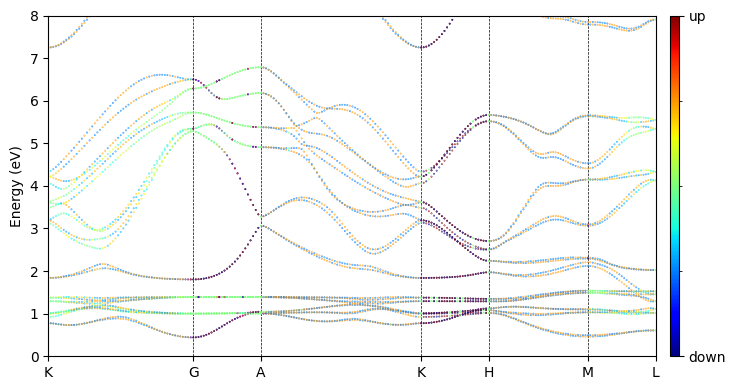

In [15]:
p_kssnn=np.zeros((nk, 2, 2, m, m), complex)
sign=[+1,+1,-1,-1]
for a in range(len(calc.atoms)):
    for q in range(nk):
        for s in range(2):
            P_mi = calc.wfs.kpt_qs[q][s].P_ani[a]
            p_kssnn[q,s,s] += sign[a]*np.dot(P_mi.conj(), P_mi.T)
    # p_kssnn=np.einsum('ab,kbcij,cd->kadij', C_ss.T.conj(), p_kssnn, C_ss, optimize=True)
p_kmm=np.einsum('kain,kabij,kbjn->kn',v_ksnm.conj(),p_kssnn, v_ksnm, optimize=True)
print(p_kmm.max(),p_kmm.min())
plt.figure(figsize=(8,4))
for n in range(2 * m):
    # im=plt.scatter(x_path, e_km[:,n]-ef, c=p_kmm[:,n].real, s=0.1, cmap='jet', vmin=-2, vmax=2)
    im=plt.scatter(x_path, e_km[:,n]-ef, c=sy_km[:,n,n].real, s=0.1, cmap='jet', vmin=-1, vmax=1)
cbar=plt.colorbar(im,aspect=40, pad=0.02)
cbar.ax.minorticks_on()
# cbar.ax.set_yticks([-2,2])
# cbar.ax.set_yticklabels(['Te', 'Mn'])
cbar.ax.set_yticks([-1,1])
cbar.ax.set_yticklabels(['down', 'up'])
plt.ylim(0, 8)
plt.xlim(x_path[0], x_path[-1])
plt.xticks(x_ticks, x_labels)
for x_ in x_ticks:
    plt.axvline(x_, c='k', lw=0.5, ls='--', zorder=-np.inf)
plt.ylabel('Energy (eV)')
plt.axhline(0, c='k', lw=0.5, ls='--', zorder=-np.inf)
# plt.minorticks_on()
plt.tight_layout()
plt.savefig('bands_spin.pdf', dpi=300,bbox_inches='tight')

In [12]:
m, ef

(30, np.float64(6.885145845031927))

(1.9927470974666806-4.336808689942018e-18j) (-0.8852023244428158-2.3784685158900754e-18j)


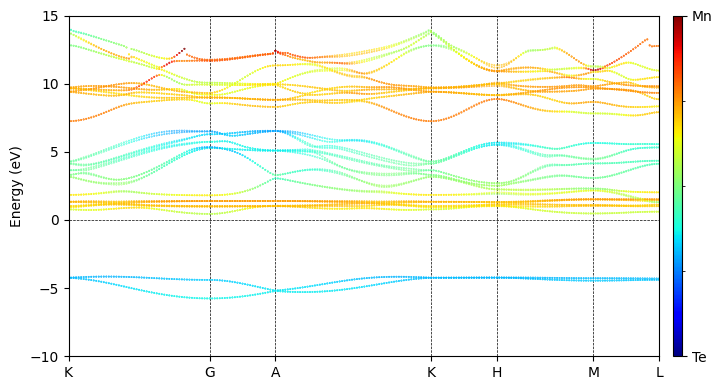

In [ ]:

ef = 0
p_kssnn=np.zeros((nk, 2, 2, m, m), complex)
sign=[+1,+1,-1,-1]
for a in range(len(calc.atoms)):
    for q in range(nk):
        for s in range(2):
            P_mi = calc.wfs.kpt_qs[q][s].P_ani[a]
            p_kssnn[q,s,s] += sign[a]*np.dot(P_mi.conj(), P_mi.T)
    # p_kssnn=np.einsum('ab,kbcij,cd->kadij', C_ss.T.conj(), p_kssnn, C_ss, optimize=True)
p_kmm=np.einsum('kain,kabij,kbjn->kn',v_ksnm.conj(),p_kssnn, v_ksnm, optimize=True)
print(p_kmm.max(),p_kmm.min())
plt.figure(figsize=(8,4))
for n in range(2 * m):
    im=plt.scatter(x_path, e_km[:,n]-ef, c=p_kmm[:,n].real, s=0.1, cmap='jet', vmin=-2, vmax=2)
    # im=plt.scatter(x_path, e_km[:,n]-ef, c=sz_km[:,n,n].real, s=0.1, cmap='jet', vmin=-1, vmax=1)
cbar=plt.colorbar(im,aspect=40, pad=0.02)
cbar.ax.minorticks_on()
cbar.ax.set_yticks([-2,2])
cbar.ax.set_yticklabels(['Te', 'Mn'])
# cbar.ax.set_yticks([-1,1])
# cbar.ax.set_yticklabels(['down', 'up'])
plt.ylim(-50, 15)
plt.xlim(x_path[0], x_path[-1])
plt.xticks(x_ticks, x_labels)
for x_ in x_ticks:
    plt.axvline(x_, c='k', lw=0.5, ls='--', zorder=-np.inf)
plt.ylabel('Energy (eV)')
plt.axhline(0, c='k', lw=0.5, ls='--', zorder=-np.inf)
# plt.minorticks_on()
plt.tight_layout()
plt.savefig('bands_atom.pdf', dpi=300,bbox_inches='tight')